# Language Modeling : make-more

Character level language model

In [1536]:
words = open('names.txt').read().splitlines()

In [1537]:
words[:5] , len(words) , min(len(w) for w in words) , max(len(w) for w in words)

(['emma', 'olivia', 'ava', 'isabella', 'sophia'], 32033, 2, 15)

Bigram language model 

In [1538]:
b = {}
for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    for c1, c2 in zip(chs, chs[1:]):
        bigram = (c1, c2)
        b[bigram] = b.get(bigram, 0) + 1

In [1539]:
sorted(b.items() , key=lambda kv: -kv[1])[:5]

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983)]

In [1540]:
import torch

In [1541]:
N = torch.zeros((27, 27), dtype=torch.int32)

In [1542]:
char = sorted(list(set(''.join(words))))
stoi = { s:i+1 for i,s in enumerate(char) }
stoi['.'] = 0
itos = { i:s for s,i in stoi.items() }

In [1543]:

for w in words:
    chs = ['.'] + list(w) + ['.']
    for c1, c2 in zip(chs, chs[1:]):
        ix1 = stoi[c1]
        ix2 = stoi[c2]
        N[ix1, ix2] += 1

In [1544]:
itos = { i:s for s,i in stoi.items() }

(np.float64(-0.5), np.float64(26.5), np.float64(26.5), np.float64(-0.5))

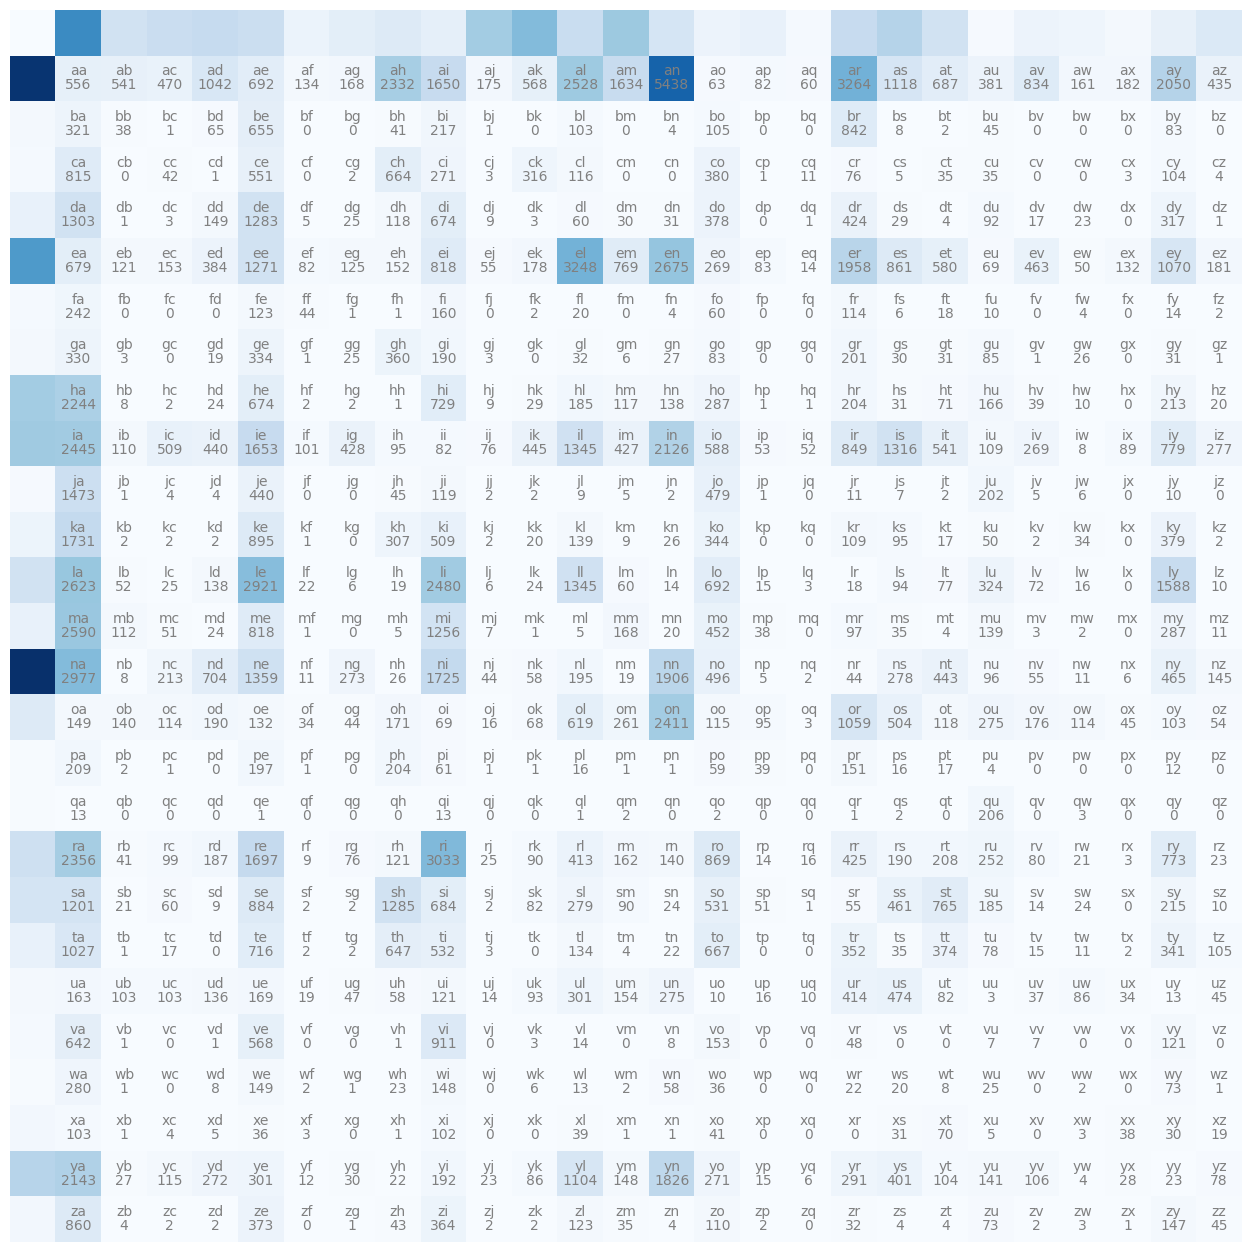

In [1545]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(1,27):
    for j in range(1,27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr , ha='center', va='bottom', color='grey')
        plt.text(j, i, N[i,j].item() , ha='center', va='top', color='grey')

plt.axis('off')

In [1546]:
N[0,:] , N[0,:].shape

(tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
         1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
          134,  535,  929], dtype=torch.int32),
 torch.Size([27]))

In [1547]:
p = N[0,:].float()
p =  p / p.sum()
p  , p.shape

(tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
         0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
         0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290]),
 torch.Size([27]))

In [1548]:
g = torch.Generator().manual_seed(2147483647)
p = torch.rand(3, generator=g)
p , p.shape

(tensor([0.7081, 0.3542, 0.1054]), torch.Size([3]))

In [1549]:
torch.multinomial(p, num_samples=100, replacement=True , generator=g)

tensor([1, 1, 2, 0, 0, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 2, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 0,
        0, 1, 1, 1])

In [1550]:
p.shape , p.sum()

(torch.Size([3]), tensor(1.1678))

In [1585]:
P = (N+1).float()
P /= P.sum(1, keepdim=True)

In [1552]:
g = torch.Generator().manual_seed(2147483647)

for i in range(10):
    out = []
    ix = 0
    while True:
     ix = torch.multinomial(P[ix], num_samples=1, replacement=True , generator=g).item()
     out.append(itos[ix])
     if ix == 0:
         break
    print(''.join(out))

cexze.
momasurailezitynn.
konimittain.
llayn.
ka.
da.
staiyaubrtthrigotai.
moliellavo.
ke.
teda.


# loss function

In [1553]:
loglikelihood = 0.0
for w in words:
    chs = ['.'] + list(w) + ['.']
    for c1, c2 in zip(chs, chs[1:]):
        ix1 = stoi[c1]
        ix2 = stoi[c2]

        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        loglikelihood += logprob
        # print(f'{c1}{c2} : {prob:.4f} {logprob:.4f}')

print(f'loglikelihood: {loglikelihood}')
nll = -loglikelihood
print(f'negative loglikelihood: {nll}')
print(f'average negative loglikelihood per bigram: {nll / N.sum()}')

loglikelihood: -559951.5625
negative loglikelihood: 559951.5625
average negative loglikelihood per bigram: 2.4543561935424805


# Create the training set of all the bigram

In [1554]:
xs , ys = [], []

for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for c1, c2 in zip(chs, chs[1:]):
        ix1 = stoi[c1]
        ix2 = stoi[c2]

        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

        

In [1555]:
xs , ys , xs.shape , ys.shape

(tensor([ 0,  5, 13, 13,  1]),
 tensor([ 5, 13, 13,  1,  0]),
 torch.Size([5]),
 torch.Size([5]))

(torch.Size([5, 27]),
 torch.float32,
 tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.]]))

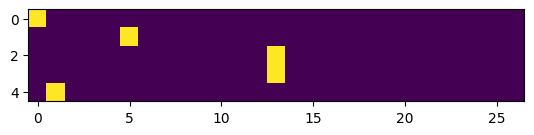

In [1556]:
# one hot encoding 

import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float()
xenc.shape , plt.imshow(xenc) , xenc.dtype , xenc

In [1557]:
W = torch.randn((27, 27), requires_grad=True)
xenc @ W , (xenc @ W).shape


(tensor([[ 0.5440, -0.8556, -0.4644, -2.4447, -0.5360, -1.0796,  0.3090, -0.7853,
          -0.7910, -0.2485,  0.5729,  0.9369, -0.8989,  1.0263,  1.3578,  1.0548,
           0.6851,  1.0919,  2.0809,  0.8126,  0.3878, -1.0479, -0.2710, -1.1803,
           0.5166,  0.6086, -0.4594],
         [-0.3514,  0.2330, -1.6368,  1.3058, -0.5042, -0.3648,  0.1862, -0.0304,
           0.8114, -0.4598, -1.1029, -0.5686,  0.6376,  1.3427, -0.7411, -1.2185,
          -1.9928, -0.5525,  0.4125, -0.7650, -1.5981,  0.4616,  2.1165,  0.4289,
          -1.1881,  0.0818,  0.8268],
         [-0.4773,  0.4631, -0.0396, -0.6689, -1.6486,  0.6762, -0.4637, -1.5969,
           1.5962,  0.4207,  1.3316,  2.0828,  0.3124,  2.0540, -0.4556,  1.7836,
          -1.7769,  0.5759, -1.3676,  0.2147, -0.8592,  2.1860,  2.8446,  1.1515,
           0.7235,  0.0820, -0.9035],
         [-0.4773,  0.4631, -0.0396, -0.6689, -1.6486,  0.6762, -0.4637, -1.5969,
           1.5962,  0.4207,  1.3316,  2.0828,  0.3124,  2.0540, -0

In [1558]:
logits = (xenc @ W)

counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)
probs

tensor([[0.0397, 0.0098, 0.0145, 0.0020, 0.0135, 0.0078, 0.0314, 0.0105, 0.0104,
         0.0180, 0.0409, 0.0588, 0.0094, 0.0643, 0.0896, 0.0662, 0.0457, 0.0687,
         0.1846, 0.0519, 0.0340, 0.0081, 0.0176, 0.0071, 0.0386, 0.0424, 0.0146],
        [0.0187, 0.0336, 0.0052, 0.0982, 0.0161, 0.0185, 0.0320, 0.0258, 0.0599,
         0.0168, 0.0088, 0.0151, 0.0503, 0.1019, 0.0127, 0.0079, 0.0036, 0.0153,
         0.0402, 0.0124, 0.0054, 0.0422, 0.2209, 0.0409, 0.0081, 0.0289, 0.0608],
        [0.0080, 0.0205, 0.0124, 0.0066, 0.0025, 0.0254, 0.0081, 0.0026, 0.0638,
         0.0197, 0.0489, 0.1037, 0.0177, 0.1008, 0.0082, 0.0769, 0.0022, 0.0230,
         0.0033, 0.0160, 0.0055, 0.1150, 0.2222, 0.0409, 0.0266, 0.0140, 0.0052],
        [0.0080, 0.0205, 0.0124, 0.0066, 0.0025, 0.0254, 0.0081, 0.0026, 0.0638,
         0.0197, 0.0489, 0.1037, 0.0177, 0.1008, 0.0082, 0.0769, 0.0022, 0.0230,
         0.0033, 0.0160, 0.0055, 0.1150, 0.2222, 0.0409, 0.0266, 0.0140, 0.0052],
        [0.0148, 0.0154,

In [1559]:
nlls = torch.zeros(5)

for i in range(5):
    x = xs[i].item()
    y = ys[i].item()

    print("__________")
    print(f"bigram example :{i+1} = {itos[x]}{itos[y]} (indexes {x}, {y}) ")
    print(f"input to the neural net: {x}")
    print(f"output of the neural net : {probs[i]}")
    print(f"label (actual next character): {y} ")

    p = probs[i, y]

    print(f"probability assigned by the net to the correct next character: {p.item()}")
    logp = torch.log(p)
    print(f"log likelihood of the correct next character: {logp.item()}")
    nll = -logp
    print(f"negative log likelihood of the correct next character: {nll.item()}")
    nlls[i] = nll

print("__________")
print(f"average negative log likelihood: {nlls.mean().item()}")

__________
bigram example :1 = .e (indexes 0, 5) 
input to the neural net: 0
output of the neural net : tensor([0.0397, 0.0098, 0.0145, 0.0020, 0.0135, 0.0078, 0.0314, 0.0105, 0.0104,
        0.0180, 0.0409, 0.0588, 0.0094, 0.0643, 0.0896, 0.0662, 0.0457, 0.0687,
        0.1846, 0.0519, 0.0340, 0.0081, 0.0176, 0.0071, 0.0386, 0.0424, 0.0146],
       grad_fn=<SelectBackward0>)
label (actual next character): 5 
probability assigned by the net to the correct next character: 0.007829640991985798
log likelihood of the correct next character: -4.849838733673096
negative log likelihood of the correct next character: 4.849838733673096
__________
bigram example :2 = em (indexes 5, 13) 
input to the neural net: 5
output of the neural net : tensor([0.0187, 0.0336, 0.0052, 0.0982, 0.0161, 0.0185, 0.0320, 0.0258, 0.0599,
        0.0168, 0.0088, 0.0151, 0.0503, 0.1019, 0.0127, 0.0079, 0.0036, 0.0153,
        0.0402, 0.0124, 0.0054, 0.0422, 0.2209, 0.0409, 0.0081, 0.0289, 0.0608],
       grad_fn=<Sel

In [1560]:
xs , ys

(tensor([ 0,  5, 13, 13,  1]), tensor([ 5, 13, 13,  1,  0]))

In [1561]:
xs , ys = [], []    

for w in words:
    chs = ['.'] + list(w) + ['.']
    for c1, c2 in zip(chs, chs[1:]):
        ix1 = stoi[c1]
        ix2 = stoi[c2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()

print(f'{num} bigrams in the dataset')

# Intialize the network

g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

228146 bigrams in the dataset


In [1588]:
# gradient descent
for k in range(10):
    #forward pass
    xenc = F.one_hot(xs, num_classes=27).float()
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdim=True)
    loss = -probs[torch.arange(num), ys].log().mean()+ 0.01*(W**2).mean()

    # backward pass
    W.grad = None
    loss.backward()

    # update
    W.data += -50 * W.grad
print(f'{k+1:4d} loss: {loss.item():.4f}' )

  10 loss: 2.4808


In [1589]:
#sample from the model
g = torch.Generator().manual_seed(2147483647)
for i in range(10):
    out = []
    ix = 0
    while True:
        xenc= F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = xenc @ W
        counts = logits.exp()
        probs = counts / counts.sum()
        ix = torch.multinomial(probs, num_samples=1, replacement=True , generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

cexze.
momasurailezityha.
konimittain.
llayn.
ka.
da.
staiyaubrtthrigotai.
moliellavo.
ke.
teda.
